In [1]:
# Imports basics
import os
import numpy as np
import h5py
import json
#import setGPU
import sklearn
#import corner
import scipy
import time
from tqdm import tqdm 
#import utils #import *
import sys
import glob
#import models
#import losses
# Imports neural net tools
import itertools
import torch
import torch.nn as nn
from torch.autograd.variable import *
import torch.optim as optim
import torch.nn.functional as F
#from fast_soft_sort.pytorch_ops import soft_rank
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score,  auc

from sklearn.preprocessing import OneHotEncoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)


# Loss Testing


In [14]:
import contrastive_losses
import importlib

In [138]:
t_out.size()

torch.Size([200, 1, 20])

## SimCLR

In [123]:
importlib.reload(contrastive_losses)
contrastive_losses.SimCLRLoss().forward2(torch.rand(10,10,10), labels = torch.rand(10))

tensor(20.6039)

In [137]:
importlib.reload(contrastive_losses)
t_out = torch.rand(200,1,20)
contrastive_losses.SimCLRLoss().forward2(t_out, labels = torch.argmax(l[0:200], dim=1))

tensor(29.1921)

## CorrLoss

In [159]:
importlib.reload(contrastive_losses)
contrastive_losses.CorrLoss()(torch.rand(10,1,20), torch.rand(10))

RuntimeError: The size of tensor a (20) must match the size of tensor b (10) at non-singleton dimension 2

In [19]:
jet_f=torch.load('100k_jet_f')
l= torch.load('100k_l')
x_sv =torch.load('100k_x_sv')
x_pf = torch.load('100k_x_pf')

In [139]:
mask_0 = l[:,0] == 1
mask_1 = l[:,1] == 1
mask_2 = l[:,2] == 1
mask_3 = l[:,3] == 1

In [14]:
x_sv_0 = x_sv[mask_0]
x_sv_1 = x_sv[mask_1]
x_sv_2 = x_sv[mask_2]
x_sv_3 = x_sv[mask_3]

In [15]:
x_pf_0 = x_pf[mask_0]
x_pf_1 = x_pf[mask_1]
x_pf_2 = x_pf[mask_2]
x_pf_3 = x_pf[mask_3]

In [16]:
jet_f_0 = jet_f[mask_0]
jet_f_1 = jet_f[mask_1]
jet_f_2 = jet_f[mask_2]
jet_f_3 = jet_f[mask_3]

# Outline of jet augmentations
1) Batch of N sample jets (N is O(100))

2) To each jet apply two augmentations

3) Label samples positive/negative based on jet label (4 labels or 2 labels)

4) Use some contrastive loss to caculate loss pairwise on all combos augmented jets from (1,2,...,2N-1, 2N)


## Jet augmentations
We can define a family of augmentations including:
- gaussian jet spatial translation
- uniformly random rotations about jet axis
- soft component smearing

In quantum field theory, gluons are elementary particles that mediate the strong force, which is responsible for the interactions between quarks and other gluons. When energetic particles such as quarks or gluons are produced in high-energy collisions, they undergo a process called jet formation, where they quickly evolve into collimated sprays of particles.

Soft gluon radiation refers to the emission of low-energy gluons during the jet formation process. These gluons have relatively small momenta compared to the hard physics involved in the initial collision. Quantum field theory predicts that the soft gluon radiation is universal, meaning that it is independent of the specific details of the hard physics that led to the jet formation.

Factorization is a concept in quantum field theory that allows us to separate the physics of the hard process (the initial collision) from the soft gluon radiation. It states that the calculations for the hard physics and the soft gluon radiation can be done independently and then combined together.

To incorporate this factorization invariance into a numerical simulation or analysis, one approach is to augment the jets by smearing the positions of the soft constituents. The constituents of a jet are the individual particles within the jet spray. In this case, the soft constituents refer to the low-energy gluons that were emitted during the jet formation.

To smear the positions of these soft constituents, the η and φ coordinates of each constituent are re-sampled from a Gaussian distribution centered on the original coordinates. The η coordinate (pseudorapidity) is a measure of the angle of the particle with respect to the beamline, while the φ coordinate (azimuthal angle) gives the angle in the transverse plane.

By smearing the positions of the soft constituents, we introduce randomness in their locations while preserving the overall characteristics of the jet. This smearing procedure helps to account for the universal nature of soft gluon radiation and ensures that the calculations properly include the effects of these radiated particles.

In [23]:
c_jet_f,c_l,c_x_sv,c_x_pf =jet_f[0], l[0], x_sv[0], x_pf[0]

In [41]:
_singleton_labels = ['zpr_fj_pt','zpr_fj_eta','zpr_fj_phi','zpr_fj_msd','zpr_fj_n2b1','zpr_fj_particleNetMD_Xbb','zpr_fj_particleNetMD_Xcc','zpr_fj_particleNetMD_Xqq','zpr_fj_particleNetMD_QCD']
_p_features_labels=['zpr_PF_pt','zpr_PF_ptrel','zpr_PF_eta','zpr_PF_etarel','zpr_PF_phi', 'zpr_PF_phirel','zpr_PF_d0','zpr_PF_dz']
_SV_features_labels=["zpr_SV_mass","zpr_SV_dlen","zpr_SV_dlenSig","zpr_SV_dxy","zpr_SV_dxySig","zpr_SV_chi2","zpr_SV_ptrel","zpr_SV_x","zpr_SV_y","zpr_SV_z","zpr_SV_pAngle","zpr_SV_etarel","zpr_SV_phirel","zpr_SV_eta","zpr_SV_phi","zpr_SV_pt"]

In [33]:
print(f'Jet feature data: {_singleton_labels}')

Jet feature data: ['zpr_fj_pt', 'zpr_fj_eta', 'zpr_fj_phi', 'zpr_fj_msd', 'zpr_fj_n2b1', 'zpr_fj_particleNetMD_Xbb', 'zpr_fj_particleNetMD_Xcc', 'zpr_fj_particleNetMD_Xqq', 'zpr_fj_particleNetMD_QCD']


In [42]:
c_l

tensor([0., 0., 1., 0.])

In [43]:
print(f'Jet lable:[Z\'(bb),Z\'(cc),Z\'(qq),QCD]')

Jet lable:[Z'(bb),Z'(cc),Z'(qq),QCD]


In [49]:
c_x_pf[0,0:-5]

tensor([ 2.8975e+02,  5.2100e-01, -6.7236e-01,  3.6377e-02,  1.6738e+00,
        -2.3193e-02,  0.0000e+00,  0.0000e+00])

In [47]:
print(f'particle feature data: {_p_features_labels})


particle feature data: ['zpr_PF_pt', 'zpr_PF_ptrel', 'zpr_PF_eta', 'zpr_PF_etarel', 'zpr_PF_phi', 'zpr_PF_phirel', 'zpr_PF_d0', 'zpr_PF_dz']
The last 5 elemenst are hot encodings


In [50]:
c_x_pf[0,-5:]

tensor([1., 0., 0., 0., 0.])

In [51]:
print(f'Particle lable:[charged hadron, neutral hadron, photon, electron, muon]')

Particle lable:[charged hadron, neutral hadron, photon, electron, muon]


In [69]:
_p_features_labels[-2]

'zpr_PF_d0'

# Jet Spatial Translations

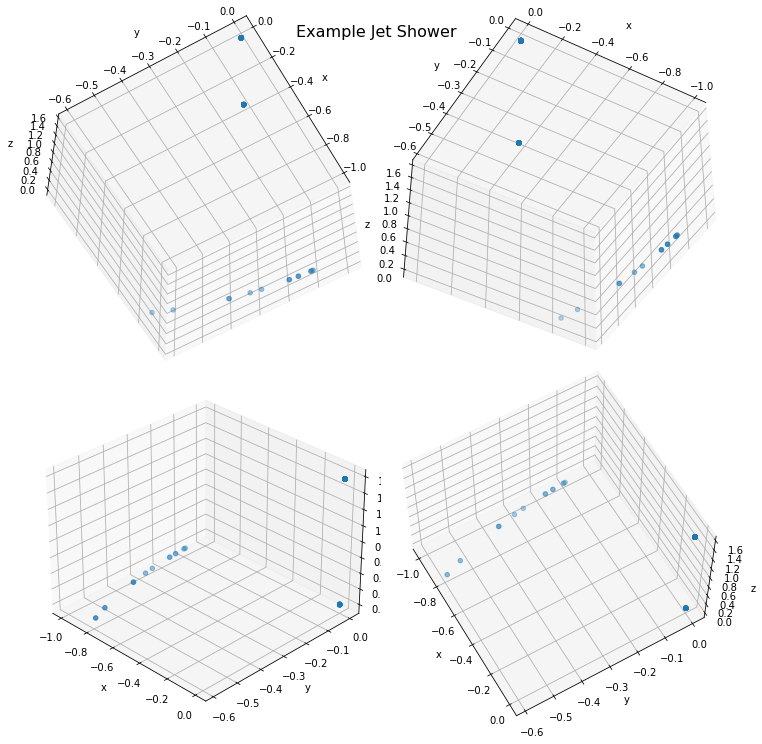

In [77]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Generate random η and φ values

d0 = c_x_pf[:,-2]
dz= c_x_pf[:,-1]
eta = c_x_pf[:,2]
phi = c_x_pf[:,4]

# Convert η and φ to Cartesian coordinates (x, y, z)

x = -d0 * np.sin(phi)
y = d0 * np.cos(phi)
z = dz * 2*np.arctan(np.e**(-eta))
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(10, 10))

# List of angles for each subplot
angles = [(-60, 30), (-45, 60), (30, -45), (60, -30)]

# Plot the points with different angles
for ax, angle in zip(axs.flatten(), angles):
    ax.scatter(x, y, z)
    ax.view_init(elev=angle[0], azim=angle[1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    

# Adjust spacing and layout
fig.tight_layout()

fig.suptitle('Example Jet Shower', fontsize=16)
# Show the plot
plt.show()


tensor([ 5.5600e+02, -7.0874e-01,  1.6968e+00,  5.1812e+01,  2.9419e-01,
         1.0042e-03,  1.1462e-01,  7.3633e-01,  1.4807e-01])

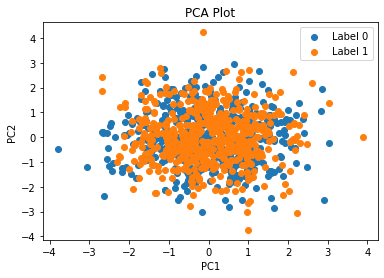

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Generate random N-dimensional binary-labeled data
N = 1000  # Number of instances
D = 10  # Number of dimensions
labels = np.random.randint(0, 2, N)  # Binary labels
data = np.random.randn(N, D)  # Random N-dimensional data

# Apply PCA to reduce dimensionality to 2 for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# Separate data points based on labels
data_label0 = data_pca[labels == 0]
data_label1 = data_pca[labels == 1]

# Create the PCA plot
plt.scatter(data_label0[:, 0], data_label0[:, 1], label='Label 0')
plt.scatter(data_label1[:, 0], data_label1[:, 1], label='Label 1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Plot')
plt.legend()
plt.show()

## Pretraining KNN Masking

In [6]:
from torch.utils.data import DataLoader
train_loader = DataLoader(data_train, batch_size=20,shuffle=True,multiprocessing_context='spawn',num_workers=16)#,pin_memory=True)
val_loader = DataLoader(data_val, batch_size=20,shuffle=True,multiprocessing_context='spawn',num_workers=16)#,pin_memory=True)

In [52]:
index = np.random.randint(100)
k = 9
from sklearn.neighbors import NearestNeighbors

  # Number of neighbors to consider
knn = NearestNeighbors(n_neighbors=k)

knn.fit(np.array(ex_jet[:,0:3]))
distances, indices = knn.kneighbors(np.array(torch.unsqueeze(ex_jet[index,0:3],dim=0)))

In [53]:
distances, indices

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[64, 57, 61, 58, 63, 62, 59, 67, 60]]))

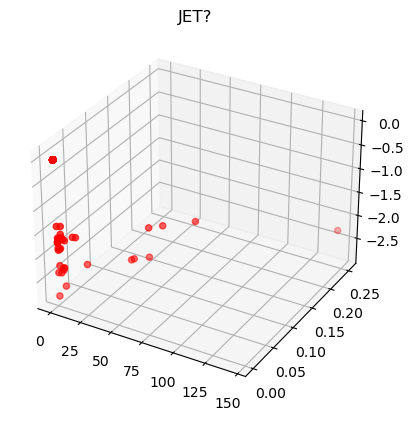

In [58]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ex_jet[:,0], ex_jet[:,1], ex_jet[:,2], c='r', marker='o')
plt.title('JET?')
plt.show()